In [14]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ttest_ind
from IPython.display import display, Markdown
import numpy as np

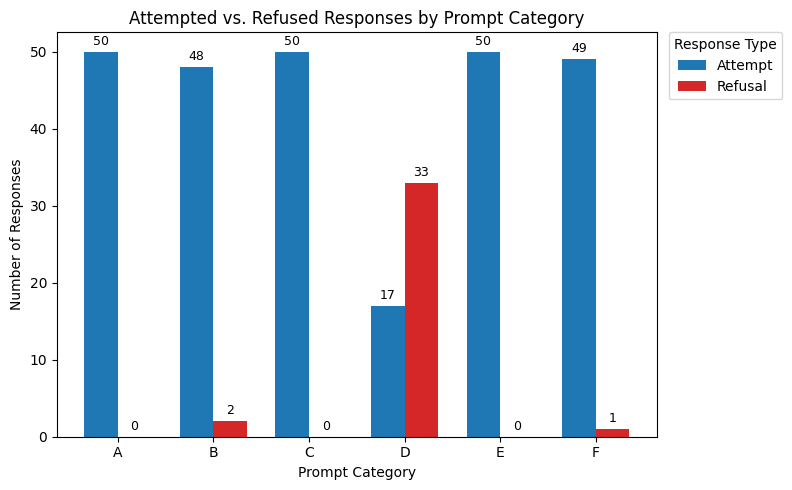

In [15]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your enriched outputs JSON (adjust path)
with open("/Users/hugomoreno/thesis-hallucination/data/intermediate/outputs_enriched.json", "r") as f:
    df = pd.DataFrame(json.load(f))

# 2. Flag refusals vs attempts
df['refusal'] = np.where(df['completeness'] == 0, 'Refusal', 'Attempt')

# 3. Count by category & flag
counts = (
    df
    .groupby(['category','refusal'])
    .size()
    .unstack(fill_value=0)
    .reindex(index=sorted(df['category'].unique()))  # ensure A–F order
)

# 4. Plot grouped bars
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(counts))            # one position per category
width = 0.35                          # bar width

ax.bar(x - width/2, counts['Attempt'], width, label='Attempt', color='tab:blue')
ax.bar(x + width/2, counts['Refusal'], width, label='Refusal', color='tab:red')

# 5. Labels & formatting
ax.set_xticks(x)
ax.set_xticklabels(counts.index, rotation=0)
ax.set_xlabel("Prompt Category")
ax.set_ylabel("Number of Responses")
ax.set_title("Attempted vs. Refused Responses by Prompt Category")
ax.legend(title="Response Type")
ax.legend(
    title="Response Type",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout(rect=[0,0,0.85,1])


# 6. Annotate values on bars
for idx, cat in enumerate(counts.index):
    for i, col in enumerate(['Attempt','Refusal']):
        val = counts.loc[cat, col]
        ax.text(
            x[idx] + ( -width/2 if col=='Attempt' else +width/2 ),
            val + 0.5,
            str(val),
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()

# 7. Save & show
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)
fig.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/attempt_vs_refusal_by_category.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Load enriched data
with open("/Users/hugomoreno/thesis-hallucination/data/intermediate/outputs_enriched.json", "r") as f:
    data = json.load(f)

# Build DataFrame with all categories
df = pd.DataFrame(data)

# Display basic info
print("Loaded enriched data with categories:", df['category'].unique())

Loaded enriched data with categories: ['A' 'B' 'C' 'D' 'E' 'F']


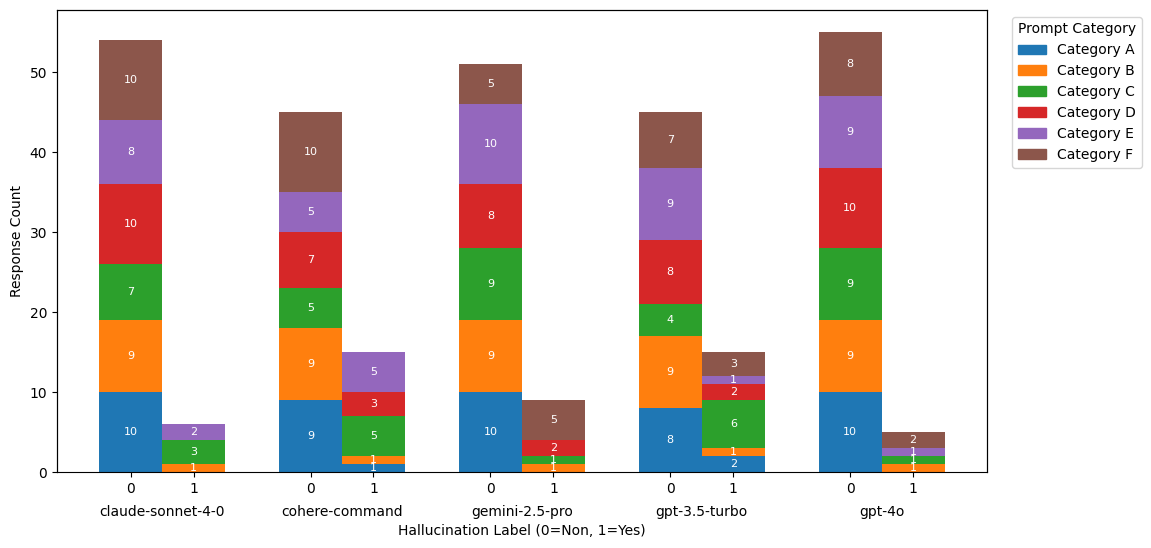

In [ ]:
#Identify models and categories
models     = sorted(df['model'].unique())
categories = sorted(df['category'].unique())

# 3. Pivot counts: (model, hallucination, category) → count
counts = df.groupby(['model','hallucination','category']) \
           .size() \
           .unstack(fill_value=0)

# 4. Build arrays: rows=models, cols=categories
data_non = np.array([
    counts.loc[(m, 0), categories] if (m,0) in counts.index else [0]*len(categories)
    for m in models
])
data_hall = np.array([
    counts.loc[(m, 1), categories] if (m,1) in counts.index else [0]*len(categories)
    for m in models
])

# 5. Choose a color for each category
palette = plt.get_cmap('tab10')
colors  = {cat: palette(i) for i, cat in enumerate(categories)}

# 6. Plot grouped, stacked bars with labels
fig, ax = plt.subplots(figsize=(12, 6))
x     = np.arange(len(models))
width = 0.35

# Non-hallucinated
bottom = np.zeros(len(models))
for idx, cat in enumerate(categories):
    bars = ax.bar(
        x - width/2,
        data_non[:, idx],
        width,
        bottom=bottom,
        color=colors[cat]
    )
    # Annotate each segment
    for bar, val in zip(bars, data_non[:, idx]):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + val/2,
                str(val),
                ha='center', va='center',
                color='white', fontsize=8
            )
    bottom += data_non[:, idx]

# Hallucinated
bottom = np.zeros(len(models))
for idx, cat in enumerate(categories):
    bars = ax.bar(
        x + width/2,
        data_hall[:, idx],
        width,
        bottom=bottom,
        color=colors[cat]
    )
    # Annotate each segment
    for bar, val in zip(bars, data_hall[:, idx]):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + val/2,
                str(val),
                ha='center', va='center',
                color='white', fontsize=8
            )
    bottom += data_hall[:, idx]

# 7. Primary X-axis: Model names at group centers
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0, ha='right')
ax.set_xlabel("Model")
ax.set_xlabel("Hallucination Label (0=Non, 1=Yes)")
ax.spines['bottom'].set_position(('outward', 20))
ax.tick_params(axis='x', which='both', length=0)        # no tick marks
ax.spines['bottom'].set_visible(False)  

# 8. Secondary X-axis: Hallucination label below each bar
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

# positions for the 0/1 ticks
h_ticks, h_labels = [], []
for xi in x:
    h_ticks += [xi - width/2, xi + width/2]
    h_labels += ['0','1']
ax2.set_xticks(h_ticks)
ax2.set_xticklabels(h_labels)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 0))  # move it down

# 9. Legend for categories
handles = [Patch(color=colors[c], label=f"Category {c}") for c in categories]
ax.legend(handles=handles, title="Prompt Category", 
          bbox_to_anchor=(1.02,1), loc='upper left')

ax.set_ylabel("Response Count")
ax.set_title("Responses by Model and Hallucination (bars) - Stacked by Prompt Category")


# Save and show
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)
fig.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/model_halluc_category_counts.png", dpi=300, bbox_inches='tight')
plt.show()


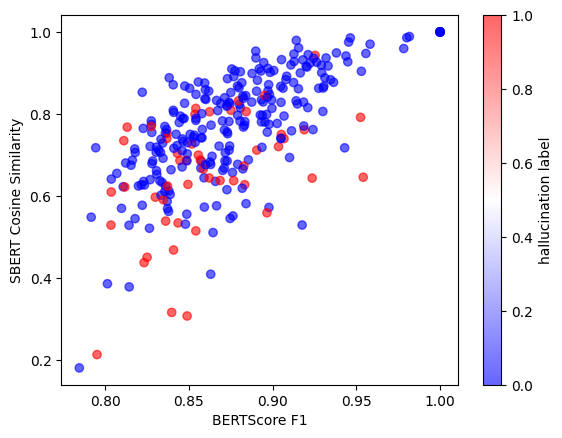

In [ ]:
# Ensure the output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)

# Your scatter plot code
plt.figure()
plt.scatter(df['bert_f1'], df['cos_sim'], c=df['hallucination'], cmap='bwr', alpha=0.6)
plt.xlabel('BERTScore F1')
plt.ylabel('SBERT Cosine Similarity')
plt.title('BERTScore F1 vs SBERT Cosine Similarity by Hallucination (All Categories)')
plt.colorbar(label='hallucination label')

# Save to file (before plt.show())
plt.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/bertf1_vs_cosim_scatter.png", dpi=300, bbox_inches="tight")

# Then display interactively if you like
plt.show()

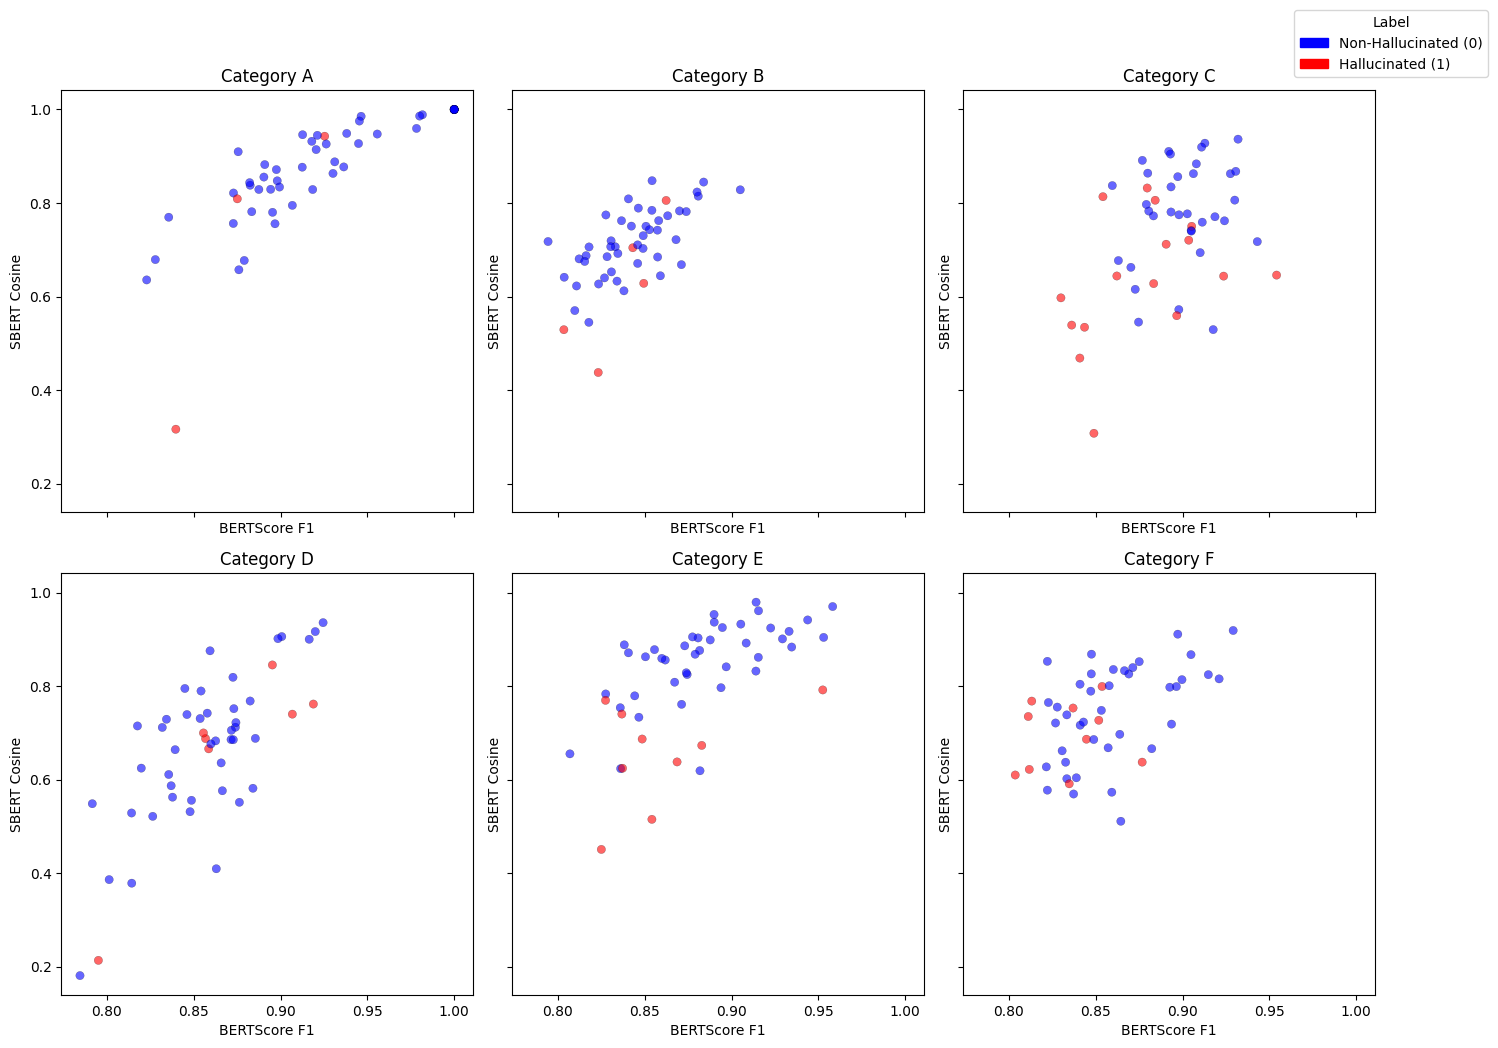

In [ ]:
# 2. Prepare faceted scatter by category
categories = sorted(df['category'].dropna().unique())
n = len(categories)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)

# 3. Plot each facet with discrete red/blue colors
for ax, cat in zip(axes.flatten(), categories):
    sub = df[df['category'] == cat]
    colors = sub['hallucination'].map({0: 'blue', 1: 'red'})
    ax.scatter(
        sub['bert_f1'],
        sub['cos_sim'],
        c=colors,
        alpha=0.6,
        edgecolor='k',
        linewidth=0.2
    )
    ax.set_title(f'Category {cat}')
    ax.set_xlabel('BERTScore F1')
    ax.set_ylabel('SBERT Cosine')

# 4. Hide any unused subplots
for ax in axes.flatten()[n:]:
    ax.set_visible(False)

# 5. Create a single legend for the figure
legend_handles = [
    Patch(color='blue', label='Non-Hallucinated (0)'),
    Patch(color='red',  label='Hallucinated (1)')
]
fig.legend(
    handles=legend_handles,
    loc='upper right',
    title='Label',
    bbox_to_anchor=(1, 1.05)
)

plt.suptitle('BERTScore F1 vs SBERT Cosine Similarity by Prompt Category', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 0.93, 1])  # leave room on right for legend

  

# 3. Save and show
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)
fig.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/bertf1_vs_cosim_by_category.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# 2. Define the prompt‐level features you want to summarize
prompt_features = [
    'token_len', 'char_len', 'entity_count',
    'pronoun_ratio', 'imperative_flag',
    'readability_score', 'punct_density'
]

# 3. Group by hallucination and compute mean, std, count
grouped = (
    df
    .groupby('hallucination')[prompt_features]
    .agg(['mean','std'])
    .round(3)
)

# 4. Flatten the MultiIndex columns
grouped.columns = ['_'.join(col) for col in grouped.columns]
grouped = (
    grouped
    .reset_index()
    .rename(columns={'hallucination':'Hallucination'})
)

# 5. Display as a Markdown table
md = grouped.to_markdown(index=False)
display(Markdown("### Prompt‐Level Features by Hallucination Label"))
display(Markdown(md))

# 6. (Optional) Save to CSV for later
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)
grouped.to_csv("/Users/hugomoreno/thesis-hallucination/result/tables/prompt_features_summary.csv", index=False)
print("Saved split summary to result/tables/prompt_features_by_hallucination.csv")

### Prompt‐Level Features by Hallucination Label

|   Hallucination |   token_len_mean |   token_len_std |   char_len_mean |   char_len_std |   entity_count_mean |   entity_count_std |   pronoun_ratio_mean |   pronoun_ratio_std |   imperative_flag_mean |   imperative_flag_std |   readability_score_mean |   readability_score_std |   punct_density_mean |   punct_density_std |
|----------------:|-----------------:|----------------:|----------------:|---------------:|--------------------:|-------------------:|---------------------:|--------------------:|-----------------------:|----------------------:|-------------------------:|------------------------:|---------------------:|--------------------:|
|               0 |           11.808 |           4.526 |          54.556 |         18.231 |               1.328 |              0.829 |                0.061 |               0.072 |                  0.348 |                 0.477 |                   60.753 |                  23.994 |                0.025 |               0.011 |
|               1 |           14.34  |           4.415 |          70.7   |         21.537 |               1.36  |              0.964 |                0.038 |               0.047 |                  0.36  |                 0.485 |                   53.881 |                  24.829 |                0.022 |               0.014 |

Saved split summary to result/tables/prompt_features_by_hallucination.csv


In [4]:
# Calculate summary statistics for core metrics
stats = df.groupby('hallucination')[['bert_f1', 'cos_sim']].agg(['mean', 'std']).round(3)

# Reformat MultiIndex columns
stats.columns = ['_'.join(col) for col in stats.columns]
stats = stats.reset_index().rename(columns={'hallucination': 'Hallucination'})

# Ensure output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)

# Save CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/summary_stats_core_metrics.csv"
stats.to_csv(csv_path, index=False)

# Display as a formatted markdown table
md_table = stats.to_markdown(index=False)
display(Markdown("**Summary Statistics for Core Metrics by Hallucination Label**"))
display(Markdown(md_table))

print(f"Saved core metrics summary to:\n- CSV: {csv_path}")

**Summary Statistics for Core Metrics by Hallucination Label**

|   Hallucination |   bert_f1_mean |   bert_f1_std |   cos_sim_mean |   cos_sim_std |
|----------------:|---------------:|--------------:|---------------:|--------------:|
|               0 |          0.877 |         0.044 |          0.775 |         0.132 |
|               1 |          0.86  |         0.037 |          0.656 |         0.144 |

Saved core metrics summary to:
- CSV: /Users/hugomoreno/thesis-hallucination/result/tables/summary_stats_core_metrics.csv


In [55]:
# Features to test
features_to_test = ['bert_f1', 'cos_sim']

# Calculate t-test results
results = []
for feat in features_to_test:
    grp0 = df[df['hallucination'] == 0][feat]
    grp1 = df[df['hallucination'] == 1][feat]
    if len(grp0) > 1 and len(grp1) > 1:
        t_stat, p_val = ttest_ind(grp0, grp1, equal_var=False)
        results.append({'Feature': feat, 't_stat': round(t_stat, 2), 'p_value': round(p_val, 3)})
    else:
        results.append({'Feature': feat, 't_stat': None, 'p_value': None})

# Build DataFrame
tt_df = pd.DataFrame(results)

# Display as markdown table
display(Markdown("**T-Test Results for Core Metrics by Hallucination Label**"))
display(Markdown(tt_df.to_markdown(index=False)))

# Ensure output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)

# Save as CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/core_metrics_t_tests.csv"
tt_df.to_csv(csv_path, index=False)

print(f"Saved t-test results to {csv_path}")

**T-Test Results for Core Metrics by Hallucination Label**

| Feature   |   t_stat |   p_value |
|:----------|---------:|----------:|
| bert_f1   |     2.87 |     0.005 |
| cos_sim   |     5.41 |     0     |

Saved t-test results to /Users/hugomoreno/thesis-hallucination/result/tables/core_metrics_t_tests.csv


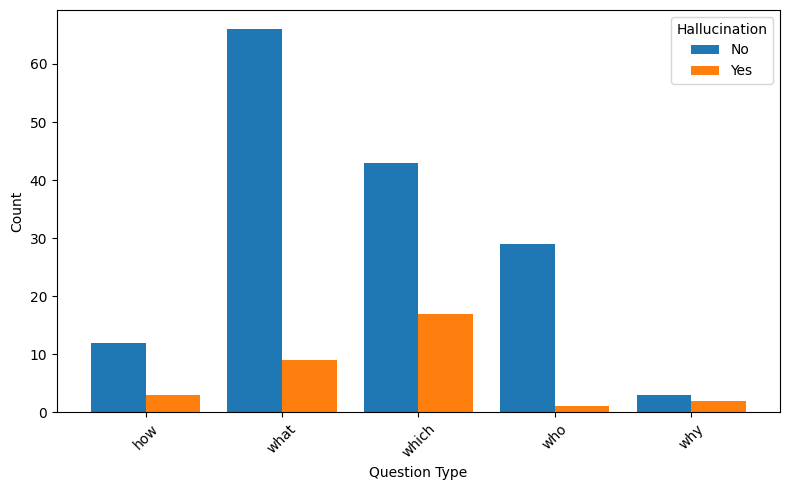

In [ ]:
# 2. Crosstab: rows = question_type, columns = hallucination flag
qt_ct = pd.crosstab(df['question_type'], df['hallucination'])

# 3. Ensure output dirs exist
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)

# 4. Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(8, 5))
qt_ct.plot(
    kind='bar',
    ax=ax,
    width=0.8,    # narrower bars so groups don’t touch
    rot=45        # rotate x‐labels if they’re long
)
ax.set_xlabel('Question Type')
ax.set_ylabel('Count')
ax.set_title('Question Type Distribution by Hallucination')
ax.legend(title='Hallucination', labels=['No', 'Yes'])
plt.tight_layout()

# 5. Show inline in the notebook
plt.show()

# 6. Save to file
fig.savefig(
    "/Users/hugomoreno/thesis-hallucination/result/figures/question_type_distribution.png",
    dpi=300,
    bbox_inches="tight"
)


In [57]:
# Baseline threshold evaluations
print("\nBaseline evaluations:")
for t in [0.85, 0.90]:
    preds = (df['bert_f1'] < t).astype(int)
    acc = accuracy_score(df['hallucination'], preds)
    f1 = f1_score(df['hallucination'], preds)
    print(f"BERT F1 < {t}: Acc = {acc:.2f}, F1 = {f1:.2f}")

# Combined threshold rule
preds_comb = ((df['bert_f1'] < 0.90) | (df['cos_sim'] < 0.75)).astype(int)
acc_c = accuracy_score(df['hallucination'], preds_comb)
f1_c = f1_score(df['hallucination'], preds_comb)
print(f"\nCombined rule (F1<0.90 or cos<0.75): Acc = {acc_c:.2f}, F1 = {f1_c:.2f}")


Baseline evaluations:
BERT F1 < 0.85: Acc = 0.66, F1 = 0.31
BERT F1 < 0.9: Acc = 0.36, F1 = 0.30

Combined rule (F1<0.90 or cos<0.75): Acc = 0.36, F1 = 0.32
